# Fungi Classification Using Macro and Micro Images

This notebook implements a CNN-based classification system for fungal species using macro and micro images. The project includes tools for data visualization, model training and evaluation, hyperparameter tuning, and performance benchmarking through confidence intervals and varying train/test splits.

! Depnding on the number of images and your PC configuration, the experiments can take longer to complete. Be patient little one! The training process takes longer only!

## Notebook Structure

- **Module Imports**  
  Loads all necessary Python libraries.

- **Hyperparameter and Parameter Configuration**  
  Sets key model parameters (e.g., learning rate, batch size, image size, data path).

- **CNN Model Construction**  
  Builds the convolutional neural network.

- **Model Training**  
  Trains the CNN on your dataset.

- **Run Model (No Hyperparameter Tuning)**  
  Executes training and evaluation using predefined parameters.

- **Run Model (With Hyperparameter Tuning)**  
  Applies automatic tuning to optimize model performance.

- **Additional Plots**  
  Generates charts for data distributions and model metrics.

- **Train/Test Split Experiment**  
  Tests model performance across different train/test ratios.

- **Confidence Interval Experiment**  
  Trains and tests the model 100 times to compute accuracy mean and standard deviation.
## Utilized Performance Metrics:

## Usage Guide

1. **Prepare Your Dataset**  
   Place your dataset in the folder: `data/yourfoldername`.

2. **Update Configuration**  
   In the configuration block, change `data_path` to your dataset folder. Modify other parameters as needed.

3. **Optional: Customize the CNN**  
   Adjust the architecture in the **CNN Model Construction** block if desired.

4. **Initialize the Environment**  
   Run all blocks up to and including **Run Model** to load functions and settings.

5. **Run Experiments**  
   Choose one or more of the following blocks to execute:
   - Run Model without Hyperparameter Tuning
   - Run Model with Hyperparameter Tuning
   - Additional Plots
   - Train/Test Split Experiment
   - Confidence Interval Experiment

In [1]:
# Module Imports

import os
import time
import gc

import numpy as np

import keras_tuner as kt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory

import keras

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, f1_score, accuracy_score,
    precision_score, recall_score
)

import matplotlib.pyplot as plt
import seaborn as sns


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2025-06-07 12:23:23.092005: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-07 12:23:23.100856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749288203.109549 3525080 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749288203.112199 3525080 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749288203.121009 3525080 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Hyperparameters and Parameters

# Change paramers as needed. 
# - To run on other datasets, change 'data_path'
# - To use early stopping, set 'EarlyStopping' to True
# - To use hyperparameter tuning, set 'tuner' to True

params = {
    'data_path': 'data/micro',
    'image_size': (128, 128),
    'batch_size': 32,
    'epochs': 30,
    'test_split': 0.2,
    'validation_split': 0.1,
    'random_seed': 42,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'shuffle': True,
    'EarlyStopping': False,
    'tuner': False,
    'verbose': True
}

In [3]:
# Load and Split Data

def get_dataset():
    # Load dataset
    dataset = image_dataset_from_directory(
        params['data_path'],
        image_size=params['image_size'],
        batch_size=params['batch_size'],
        seed=params['random_seed']
    )

    # Shuffle it before splits
    dataset.shuffle(params['shuffle'])

    # Split into training, testing and validation
    train_ds = dataset.take(int((1 - params['test_split']) * len(dataset)))
    test_ds = dataset.skip(int((1 - params['test_split']) * len(dataset)))
    test_ds = test_ds.take(int((1 - params['validation_split']) * len(test_ds)))
    validation_ds = test_ds.skip(int((1 - params['validation_split']) * len(test_ds)))


    class_names = dataset.class_names
    class_counts = {cls: len(os.listdir(os.path.join(params['data_path'], cls))) for cls in class_names}

    return dataset,train_ds, test_ds, validation_ds, class_names, class_counts

In [4]:
# Build CNN Model

def build_CNN_model(train_ds, validation_ds, class_names):

    def build_model_hp(hp):
        model = models.Sequential()
        model.add(layers.Input(shape=(*params['image_size'], 3)))

        # First conv layer
        model.add(layers.Conv2D(
            hp.Int('conv_1', 8, 128, step=16),
            (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D(2, 2))

        # Optional second conv layer
        if hp.Boolean('use_conv_2'):
            model.add(layers.Conv2D(
                hp.Int('conv_2', 8, 128, step=16),
                (3, 3), activation='relu'))
            model.add(layers.MaxPooling2D(2, 2))

        # Optional third conv layer
        if hp.Boolean('use_conv_3'):
            model.add(layers.Conv2D(
                hp.Int('conv_3', 8, 128, step=16),
                (3, 3), activation='relu'))
            model.add(layers.MaxPooling2D(2, 2))

        model.add(layers.Flatten())

        # First dense layer
        model.add(layers.Dense(
            hp.Int('dense_1', 8, 128, step=16),
            activation='relu'))

        # Optional second dense layer
        if hp.Boolean('use_dense_2'):
            model.add(layers.Dense(
                hp.Int('dense_2', 8, 128, step=16),
                activation='relu'))

        # Output layer
        model.add(layers.Dense(len(class_names), activation='softmax'))

        # Compile model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Choice('lr', [1e-1, 1e-2, 1e-3])
            ),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def build_model_standard(num_classes):
        model = models.Sequential([
            layers.Input(shape=(*params['image_size'], 3)),
            # layers.Rescaling(1./255, input_shape=input_shape),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D(),
            #layers.Conv2D(128, (3, 3), activation='relu'),
            #layers.MaxPooling2D(),
            layers.Flatten(),
            #layers.Dense(256, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer=optimizers.Adam(learning_rate=params['learning_rate']),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    if params['tuner']:
        # tuner = kt.Hyperband(build_model_hp, objective='val_accuracy', max_epochs=params['epochs'], directory='kt_dir', project_name='cnn_tune')
        # tuner.search(train_ds, validation_data=validation_ds, epochs=params['epochs'])
        # model = tuner.get_best_models(1)[0]

        # model.summary()

        tuner = kt.Hyperband(
            build_model_hp,
            objective='val_accuracy',
            max_epochs=params['epochs'],
            directory='kt_dir',
            project_name='cnn_tune'
        )

        # Run the hyperparameter search
        tuner.search(
            train_ds,
            validation_data=validation_ds,
            epochs=params['epochs']
        )

        # Retrieve the best model
        model = tuner.get_best_models(1)[0]

        # Optionally retrieve best hyperparameters
        best_hps = tuner.get_best_hyperparameters(1)[0]

        print("Best hyperparameters:")
        print(best_hps.values)
        
    else:
        num_classes = len(class_names)
        model = build_model_standard(num_classes = num_classes)

    return model

In [5]:
#  Model Training with params
def train_model(model, train_ds, validation_ds):

    if params['EarlyStopping']:
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        start_train = time.time()

        history = model.fit(
            train_ds,
            validation_data=validation_ds,
            epochs=params['epochs'],
            callbacks=[early_stop],
            verbose=0
        )

        end_train = time.time()
    else:
        early_stop = None

        start_train = time.time()

        history = model.fit(
            train_ds,
            validation_data=validation_ds,
            epochs=params['epochs'],
            verbose=0
        )
        end_train = time.time()

    print(f"Training time: {end_train - start_train:.2f} seconds")

    return model, history

In [14]:
# Metrics 
def compute_diagnostic_metrics(true_labels, pred_labels):

    labels = np.unique(true_labels)
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)
    
    TPR_list, TNR_list, PPV_list, NPV_list, F1_list = [], [], [], [], []
    per_class_metrics = {}

    for i, label in enumerate(labels):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)

        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity
        TNR = TN / (TN + FP) if (TN + FP) > 0 else 0  # Specificity
        PPV = TP / (TP + FP) if (TP + FP) > 0 else 0  # Precision
        NPV = TN / (TN + FN) if (TN + FN) > 0 else 0  # NPV
        F1  = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0

        TPR_list.append(TPR)
        TNR_list.append(TNR)
        PPV_list.append(PPV)
        NPV_list.append(NPV)
        F1_list.append(F1)

        per_class_metrics[label] = {
            'Sensitivity (TPR)': TPR,
            'Specificity (TNR)': TNR,
            'Positive Predictive Value (PPV)': PPV,
            'Negative Predictive Value (NPV)': NPV,
            'F1 Score': F1
        }

    overall = {
        'True_Labels': true_labels,
        'Predicted_Labels': pred_labels,
        'Accuracy': accuracy_score(true_labels, pred_labels),
        'Sensitivity (TPR)': np.mean(TPR_list),
        'Specificity (TNR)': np.mean(TNR_list),
        'Positive Predictive Value (PPV)': np.mean(PPV_list),
        'Negative Predictive Value (NPV)': np.mean(NPV_list),
        'F1 Score': np.mean(F1_list)
    }

    return overall, per_class_metrics

In [17]:
# Evaluate & Metrics 

def evaluate_model(model, test_ds, verbose=True):

    true_labels, pred_labels = [], []
    start_test = time.time()
    for images, labels in test_ds.unbatch():
        preds = model.predict(tf.expand_dims(images, axis=0), verbose=0)
        true_labels.append(labels.numpy())
        pred_labels.append(np.argmax(preds))
    end_test = time.time()



    overall, per_class_metrics = compute_diagnostic_metrics(true_labels, pred_labels)
    
    if verbose:
        print(f"Testing time: {end_test - start_test:.2f} seconds")
    
        print("Overall Results:")
        for key, value in overall.items():
            if key == 'True_Labels' or key == 'Predicted_Labels':
                continue
            print(f"{key}: {value:.4f}")

        print("\n Per Class Diagnostic Metrics:")
        for label, metrics in per_class_metrics.items():
            print(f"\nClass: {label}")
            for key, value in metrics.items():
                print(f"  {key}: {value:.4f}")

    return overall, per_class_metrics

In [7]:
# Additional Plots 

def additional_plots(model, history, class_names, class_counts, results, verbose=True):
    
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 14
    })
    
    plt.figure(figsize=(10, 4))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Dataset Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=30, ha='right', rotation_mode='anchor')
    plt.grid(True)
    plt.savefig("figs/class_distribution.pdf", format='pdf', bbox_inches='tight')


    cm = confusion_matrix(results['True_Labels'], results['Predicted_Labels'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=30, ha='right', rotation_mode='anchor')
    plt.savefig("figs/confiusion_matrix_tuner_" + str(params["tuner"]) + ".pdf", format='pdf', bbox_inches='tight')

Found 571 files belonging to 6 classes.
Training time: 209.95 seconds
Testing time: 10.30 seconds
Overall Results:
Accuracy: 1.0000
Sensitivity (TPR): 1.0000
Specificity (TNR): 1.0000
Positive Predictive Value (PPV): 1.0000
Negative Predictive Value (NPV): 1.0000
F1 Score: 1.0000

 Per Class Diagnostic Metrics:

Class: 0
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 1.0000
  Positive Predictive Value (PPV): 1.0000
  Negative Predictive Value (NPV): 1.0000
  F1 Score: 1.0000

Class: 1
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 1.0000
  Positive Predictive Value (PPV): 1.0000
  Negative Predictive Value (NPV): 1.0000
  F1 Score: 1.0000

Class: 2
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 1.0000
  Positive Predictive Value (PPV): 1.0000
  Negative Predictive Value (NPV): 1.0000
  F1 Score: 1.0000

Class: 3
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 1.0000
  Positive Predictive Value (PPV): 1.0000
  Negative Predictive Value (NPV): 1.0000
  F1 Score: 1.0000

Class: 4
 

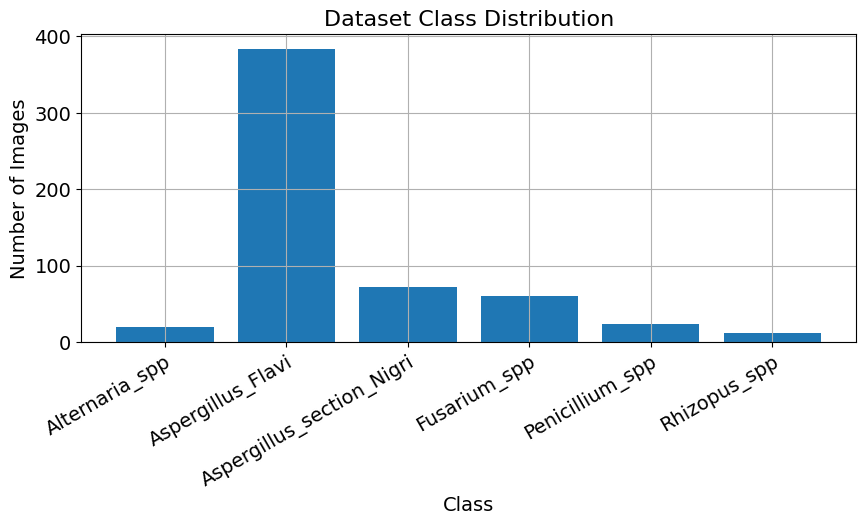

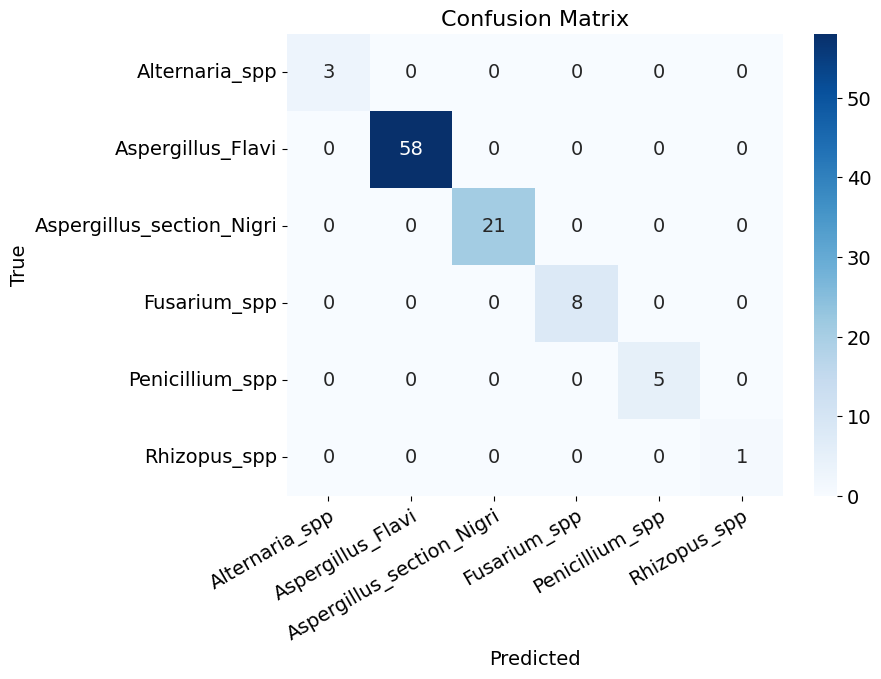

In [18]:
# Run Model without Hyperparameter Tuning

params['tuner'] = False
params['test_split'] = 0.2

dataset, train_ds, test_ds, validation_ds, class_names, class_counts = get_dataset()

model = build_CNN_model(train_ds, validation_ds, class_names)

model, history = train_model(model, train_ds, validation_ds)

results, per_class_results = evaluate_model(model, test_ds, verbose=params['verbose'])

additional_plots(model, history, class_names, class_counts, results)

In [ ]:
# Run Model with Hyperparameter Tuning (Run once if you really want optimization)
!rm -rf ./kt_dir

params['tuner'] = True

dataset, train_ds, test_ds, validation_ds, class_names, class_counts = get_dataset()

model = build_CNN_model(train_ds, validation_ds, class_names)

model, history = train_model(model, train_ds, validation_ds)

results, per_class_results = evaluate_model(model, test_ds, verbose=params['verbose'])

# additional_plots(model, history, class_names, class_counts, results)

params['tuner'] = False

In [ ]:
# Train / test percentage experiment

params['tuner'] = False
params['test_split'] = 0.2

exp_results = {}

for i in np.arange(0.1, 1.0, 0.1):
    params['test_split'] = i
    print(f"Train_percent: {1-params['test_split']}, Test_percent: {params['test_split']}")

    dataset, train_ds, test_ds, validation_ds, class_names, class_counts = get_dataset()
    model = build_CNN_model(train_ds, validation_ds, class_names)
    model, history = train_model(model, train_ds, validation_ds)
    results, per_class_results = evaluate_model(model, test_ds, verbose=False)
    exp_results[f"Test_percent: {params['test_split']}"] = results
    # additional_plots(model, history, class_names, class_counts, results)

    gc.collect()
    tf.keras.backend.clear_session()

Train_percent: 0.9, Test_percent: 0.1
Found 571 files belonging to 6 classes.
Training time: 200.48 seconds
Testing time: 3.07 seconds
Overall Results:
Accuracy: 1.0000
Sensitivity (TPR): 1.0000
Specificity (TNR): 1.0000
Positive Predictive Value (PPV): 1.0000
Negative Predictive Value (NPV): 1.0000
F1 Score: 1.0000

 Per Class Diagnostic Metrics:

Class: 0
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 1.0000
  Positive Predictive Value (PPV): 1.0000
  Negative Predictive Value (NPV): 1.0000
  F1 Score: 1.0000

Class: 1
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 1.0000
  Positive Predictive Value (PPV): 1.0000
  Negative Predictive Value (NPV): 1.0000
  F1 Score: 1.0000

Class: 2
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 1.0000
  Positive Predictive Value (PPV): 1.0000
  Negative Predictive Value (NPV): 1.0000
  F1 Score: 1.0000

Class: 3
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 1.0000
  Positive Predictive Value (PPV): 1.0000
  Negative Predictive Value (NPV): 

2025-06-07 16:22:13.690025: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Testing time: 15.14 seconds
Overall Results:
Accuracy: 1.0000
Sensitivity (TPR): 1.0000
Specificity (TNR): 1.0000
Positive Predictive Value (PPV): 1.0000
Negative Predictive Value (NPV): 1.0000
F1 Score: 1.0000

 Per Class Diagnostic Metrics:

Class: 0
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 1.0000
  Positive Predictive Value (PPV): 1.0000
  Negative Predictive Value (NPV): 1.0000
  F1 Score: 1.0000

Class: 1
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 1.0000
  Positive Predictive Value (PPV): 1.0000
  Negative Predictive Value (NPV): 1.0000
  F1 Score: 1.0000

Class: 2
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 1.0000
  Positive Predictive Value (PPV): 1.0000
  Negative Predictive Value (NPV): 1.0000
  F1 Score: 1.0000

Class: 3
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 1.0000
  Positive Predictive Value (PPV): 1.0000
  Negative Predictive Value (NPV): 1.0000
  F1 Score: 1.0000

Class: 4
  Sensitivity (TPR): 1.0000
  Specificity (TNR): 1.0000
  Positive Pred

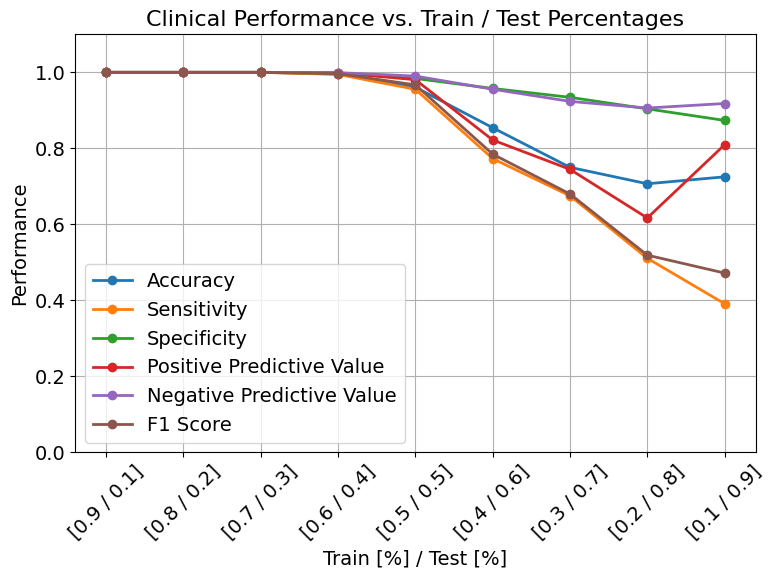

In [29]:
# Train / test percentage experiment results

x_labels = [f"[{1 - test:.1f} / {test:.1f}]" for test in np.arange(0.1, 1.0, 0.1)]
accuracies = [result['Accuracy'] for result in exp_results.values()]
tprs = [result['Sensitivity (TPR)'] for result in exp_results.values()]
tnrs = [result['Specificity (TNR)'] for result in exp_results.values()]
ppvs = [result['Positive Predictive Value (PPV)'] for result in exp_results.values()]
npvs = [result['Negative Predictive Value (NPV)'] for result in exp_results.values()]
f1s = [result['F1 Score'] for result in exp_results.values()]

# set all parameters for plot, including text sizes for everything

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 14
})

plt.figure(figsize=(8, 6))
#plt.bar(x_labels, accuracies)
plt.plot(x_labels, accuracies, marker='o', linewidth=2)
plt.plot(x_labels, tprs, marker='o', linewidth=2)
plt.plot(x_labels, tnrs, marker='o', linewidth=2)
plt.plot(x_labels, ppvs, marker='o', linewidth=2)
plt.plot(x_labels, npvs, marker='o', linewidth=2)
plt.plot(x_labels, f1s, marker='o', linewidth=2)

plt.xlabel('Train [%] / Test [%]')
plt.ylabel('Performance')
plt.title('Clinical Performance vs. Train / Test Percentages')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.legend(['Accuracy', 'Sensitivity', 'Specificity', 'Positive Predictive Value', 'Negative Predictive Value', 'F1 Score'])
plt.grid(True)
plt.tight_layout()

plt.savefig("figs/accuracy_percent_plot.pdf", format='pdf', bbox_inches='tight')

In [ ]:
# Performance over 100 repetitions of the trials

params['tuner'] = False
params['test_split'] = 0.2

exp_results_trials = {}
exp_class_results_trials = {}

for i in range(100):
    dataset, train_ds, test_ds, validation_ds, class_names, class_counts = get_dataset()
    model = build_CNN_model(train_ds, validation_ds, class_names)
    model, history = train_model(model, train_ds, validation_ds)
    results, per_class_results = evaluate_model(model, test_ds, verbose=False)
    exp_results_trials[i] = results
    exp_class_results_trials[i] = per_class_results

    gc.collect()
    tf.keras.backend.clear_session()

Found 571 files belonging to 6 classes.
Training time: 221.23 seconds
Found 571 files belonging to 6 classes.
Training time: 215.02 seconds
Found 571 files belonging to 6 classes.
Training time: 198.09 seconds
Found 571 files belonging to 6 classes.
Training time: 203.02 seconds
Found 571 files belonging to 6 classes.
Training time: 232.94 seconds
Found 571 files belonging to 6 classes.
Training time: 199.53 seconds
Found 571 files belonging to 6 classes.
Training time: 220.33 seconds
Found 571 files belonging to 6 classes.
Training time: 209.58 seconds
Found 571 files belonging to 6 classes.
Training time: 194.61 seconds
Found 571 files belonging to 6 classes.
Training time: 194.57 seconds
Found 571 files belonging to 6 classes.
Training time: 227.15 seconds
Found 571 files belonging to 6 classes.


In [ ]:
# Performance over 100 repetitions of the trials results

def get_trials_results(metric, name):
    mean_ = np.mean(metric)
    std_ = np.std(metric)
    
    print(f"Mean name: {mean_:.4f}")
    print(f"Standard Deviation name: {std_:.4f}")

print("Overall results (Macro averaging)")

accuracies = [result['Accuracy'] for result in exp_results_trials.values()]
get_trials_results(accuracies, 'Accuracy')

tprs = [result['Sensitivity (TPR)'] for result in exp_results_trials.values()]
get_trials_results(tprs, 'Sensitivity (TPR)')

tnrs = [result['Specificity (TNR)'] for result in exp_results_trials.values()]
get_trials_results(tnrs, 'Specificity (TNR)')

ppvs = [result['Positive Predictive Value (PPV)'] for result in exp_results_trials.values()]
get_trials_results(ppvs, 'Positive Predictive Value (PPV)')

npvs = [result['Negative Predictive Value (NPV)'] for result in exp_results_trials.values()]
get_trials_results(npvs, 'Negative Predictive Value (NPV)')

f1s = [result['F1 Score'] for result in exp_results_trials.values()]
get_trials_results(f1s, 'F1 Score')

print("Overall results (Micro averaging)")

for key, value in exp_class_results_trials.items():

    print(f"Results for class: {key} ")

    tprs_class = [result['Sensitivity (TPR)'] for result in value.values()]
    get_trials_results(tprs_class, 'Sensitivity (TPR)')

    tnrs_class = [result['Specificity (TNR)'] for result in value.values()]
    get_trials_results(tnrs_class, 'Specificity (TNR)')

    ppvs_class = [result['Positive Predictive Value (PPV)'] for result in value.values()]
    get_trials_results(ppvs_class, 'Positive Predictive Value (PPV)')

    npvs_class = [result['Negative Predictive Value (NPV)'] for result in value.values()]
    get_trials_results(npvs_class, 'Negative Predictive Value (NPV)')

    f1s_class = [result['F1 Score'] for result in value.values()]
    get_trials_results(f1s_class, 'F1 Score')

# Not used
# mean = np.mean(accuracies)
# std = np.std(accuracies)
# n = len(accuracies)
# ci95 = 1.96 * std / np.sqrt(n)

# x = np.arange(n)

# plt.rcParams.update({
#     'font.size': 14,
#     'axes.titlesize': 16,
#     'axes.labelsize': 14,
#     'xtick.labelsize': 14,
#     'ytick.labelsize': 14,
#     'legend.fontsize': 14,
#     'figure.titlesize': 14
# })

# plt.figure(figsize=(10, 5))
# # plt.plot(x, accuracies, label='Accuraccy')
# plt.axhline(mean, color='red', linestyle='--', label=f'Mean = {mean:.4f}')

# line plot with 95% confidence interval
#sns.lineplot(data=x, x="year", y="passengers", errorbar=("ci", 90))
# plt.fill_between(x, mean - ci95, mean + ci95, color='blue', alpha=0.2, label='95% Confidence Interval', linewidth=4)
# plt.xlabel('Run')
# plt.ylabel('Accuracy')
# plt.title('Accuracy Across 100 Runs with 95% Confidence Interval')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig("accuracy_ci_plot.pdf", format='pdf', bbox_inches='tight')